#Task 1 : Exploratory Data Analysis

### **Data Description:**

This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions.

The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights you can gather from the tasks below will be genuine.

---

The original data from this Excel format used for this analysis comes from https://www.theforage.com/modules/ZLJCsrpkHo9pZBJNY/BiJPfqmGY2QwgN6gA?ref=LW7dHDBSC956M2559.

---

### **Analysis Purpose:**

*   Start by doing some basic checks – are there any data issues? Does the data need to be cleaned?

*   Gather some interesting overall insights about the data. For example -- what is the average transaction amount? How many transactions do customers make each month, on average?

*   Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an average day or week. Consider the effect of any outliers that may distort your analysis.

*   For a challenge – what insights can you draw from the location information provided in the dataset?


Put together 2-3 slides summarising your most interesting findings to ANZ management.

**Import libraries**

In [62]:
# Required libraries for analysis
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import math

# Suppress warnings (warnings do not prevent the code from executing)
import warnings
warnings.filterwarnings("ignore")

In [63]:
# Connect to the data source, in this case a csv file stored on my G Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **1. Read Data**

In [64]:
# Upload the excel file into pandas, original Dataset from Forage website
data = pd.read_excel('/content/gdrive/My Drive/transactiondataset.xlsx')
data.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


The synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers.

It contains purchases, recurring transactions, and salary transactions.

# **2. Basic Checks**

In [65]:
# What columns are we working with?
pd.DataFrame({"Columns": data.columns})

,Columns
0,status
1,card_present_flag
2,bpay_biller_code
3,account
4,currency
5,long_lat
6,txn_description
7,merchant_id
8,merchant_code
9,first_name


In [66]:
# Let's see overall shape 
print("Data shape:" , data.shape)

Data shape: (12043, 23)


### **2.1. Unique customers, unique transactions and 3 months of data**

*   100 unique customers (customer_id)
*   Each row corresponds to a unique transaction ID (transaction_id)
*   3 months worth of data (date)




In [67]:
print("Number of unique customer ID's:", data.customer_id.nunique())

Number of unique customer ID's: 100


In [68]:
print("Number of rows in dataset:", len(data))
print("Number of unique transaction ID's:", data.transaction_id.nunique())

Number of rows in dataset: 12043
Number of unique transaction ID's: 12043


Number of unique ID's corresponds to the number of rows in the dataset which suggests that each row represents a unique transaction.

In [69]:
data.date.describe()

count                   12043
unique                     91
top       2018-09-28 00:00:00
freq                      174
first     2018-08-01 00:00:00
last      2018-10-31 00:00:00
Name: date, dtype: object

We do indeed have 3 months worth of data, starting from 1/8/2018 to 31/10/2018. However, there are only 91 unique days which means that there is one missing day.

In [70]:
pd.date_range(start = "2018-08-01", end = "2018-10-31").difference(data.date)

DatetimeIndex(['2018-08-16'], dtype='datetime64[ns]', freq=None)

We have one missing date on 16/8/2018.

### **2.2. Handling nulls and data types:**

In [71]:
# Let's see overall type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

The info function provides information about the data types and presence of missing values in each column of the dataset.

In [72]:
# Let's identify rows that contain nulls
data.isnull().values.any()

True

In [73]:
null_rows = data[data.isnull().any(axis=1)]
null_rows.head(10)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit
5,posted,NaN,NaN,ACC-1608363396,AUD,151.22 -33.87,PAYMENT,NaN,NaN,Robert,1705.43,2018-08-01,M,20,NaN,NaN,2018-08-01T02:00:00.000+0000,163.00,1005b48a6eda4ffd85e9b649dc9467d3,Australia,CUS-2688605418,NaN,debit
6,authorized,1.0,NaN,ACC-2776252858,AUD,144.95 -37.76,SALES-POS,3aa18033-a0a9-4190-a117-b7caaf4d07e3,NaN,Kristin,1248.36,2018-08-01,F,43,Kalkallo,VIC,2018-08-01T02:23:04.000+0000,61.06,b79ca208099c4c28aa5dae966096d842,Australia,CUS-4123612273,144.95 -37.53,debit
7,authorized,1.0,NaN,ACC-2776252858,AUD,144.95 -37.76,POS,ee58145d-26e8-4b01-9cd9-62378014f21d,NaN,Kristin,1232.75,2018-08-01,F,43,Melbourne,VIC,2018-08-01T04:11:25.000+0000,15.61,e1c4a50d6a0549cbb3710a62a2fa00d5,Australia,CUS-4123612273,144.96 -37.81,debit
8,authorized,1.0,NaN,ACC-182446574,AUD,116.06 -32.00,POS,cfbf535e-caa8-499f-9d41-bbdc2b836d85,NaN,Tonya,213.16,2018-08-01,F,27,Yokine,WA,2018-08-01T04:40:00.000+0000,19.25,799e39eb2c1b411185424b0f2cd18bda,Australia,CUS-3026014945,115.85 -31.9,debit
9,posted,NaN,NaN,ACC-602667573,AUD,151.23 -33.96,INTER BANK,NaN,NaN,Michael,466.58,2018-08-01,M,40,NaN,NaN,2018-08-01T06:00:00.000+0000,21.00,798a77869014441b840a7a8a23408332,Australia,CUS-2031327464,NaN,debit


In [74]:
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

### **2.3. Missing values**

In [75]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing_percentage = round(missing / len(data), 3) * 100
pd.DataFrame({"Number of missing values": missing, "Percentage": missing_percentage}).sort_values(by = "Percentage", ascending = False)

,Number of missing values,Percentage
bpay_biller_code,11158,92.7
merchant_code,11160,92.7
card_present_flag,4326,35.9
merchant_id,4326,35.9
merchant_suburb,4326,35.9
merchant_state,4326,35.9
merchant_long_lat,4326,35.9


Both bpay_biller_code and merchant_code columns contain a significant number of missing values. 

Let's examine the summary statistics of the numerical columns in the dataset.

### **2.4. Descriptive statistics**

In [76]:
data.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000



The describe function is a good way to observe any anomalies in the numerical columns for example, we can check if the age and amount columns contain any negative values, or if a customer has an age of 150 etc. Here, I do not see any anomalies.

It also provides an overview of some basic statistics for the amount column. However, we do not know the breakdown of these transaction amounts for example, what sort of transactions are they, who made them etc. We will explore this as we proceed with our further analysis.

We can see see a huge spread between the maximum and minimum amount in the balance and amount columns. We will look into this further

# **3. Exploratory data analysis (EDA)**

### **3.1. Categorical variables**

Here, we will skip the following columns as they won't provide us with much information:

*   bpay_biller_code
*   account
*   merchant_id
*   merchant_code
*   first_name
*   transaction_id
*   customer_id



**3.1.1. Status**

In [77]:
data.status.value_counts(dropna = False)

authorized    7717
posted        4326
Name: status, dtype: int64

Status of of the individual transactions: authorised means transaction has already been approved, posted means still in the process.


**3.1.2. Card present flag**

In [78]:
data.card_present_flag.value_counts(dropna = False)

1.0    6194
NaN    4326
0.0    1523
Name: card_present_flag, dtype: int64

Card-not-present (CNP) transaction occurs when neither the cardholder nor the credit card is physically present at the time of the transaction. It's most common for orders that happen remotely over the phone, internet or mail.

**3.1.3. Currency of transaction**

In [79]:
data.currency.value_counts(dropna = False)

AUD    12043
Name: currency, dtype: int64

All transactions are made in AUD. Can potentially drop this column because unnecessary since it does not provide us with any additional information.

**3.1.4. Longitude and latitude**

In [80]:
data.long_lat.head()

0    153.41 -27.95
1    153.41 -27.95
2    151.23 -33.94
3    153.10 -27.66
4    153.41 -27.95
Name: long_lat, dtype: object

These are the coordinates where the transactions were made.

**3.1.5. Types of transactions**

In [81]:
data.txn_description.value_counts(dropna = False)

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

Text(0.5, 1.0, 'Number of transactions by category')

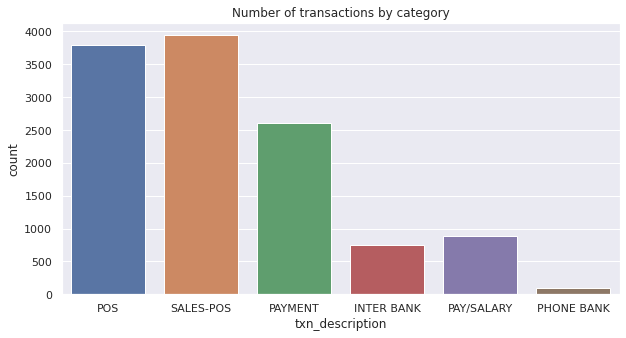

In [82]:

plt.figure(figsize = (10, 5))
sns.countplot(data.txn_description)
plt.title("Number of transactions by category")

These are the descriptions for each transaction. Transactions mostly consist of sales payment.

This might explain the missing values in the merchant columns as not all transactions are purchases of goods and services from merchants. We can validate this later.

In [83]:
data[["txn_description", "amount"]].groupby("txn_description", as_index = False).mean().sort_values(by = "amount", ascending = False)

,txn_description,amount
1,PAY/SALARY,1898.728029
3,PHONE BANK,106.099010
0,INTER BANK,86.699461
2,PAYMENT,77.613077
4,POS,40.407412
5,SALES-POS,39.909789


Text(0.5, 1.0, 'Average transaction volume by category')

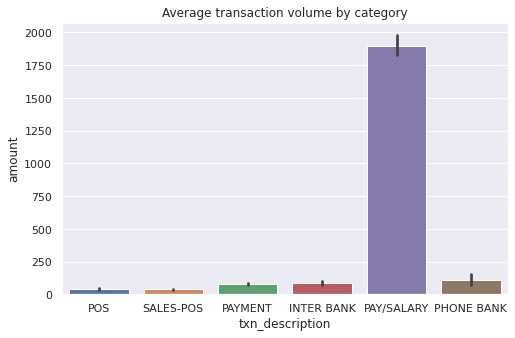

In [84]:
plt.figure(figsize = (8, 5))
sns.barplot(x = "txn_description", y = "amount", data = data)
plt.title("Average transaction volume by category")


Pay/salary has the largest average transaction volume.

**3.1.6. Gender**

In [85]:
data.gender.value_counts(dropna = False)

M    6285
F    5758
Name: gender, dtype: int64

Text(0.5, 1.0, 'Number of transactions by gender')

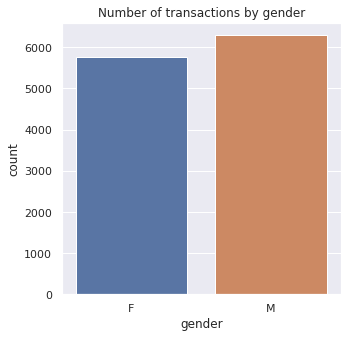

In [86]:
plt.figure(figsize = (5, 5))
sns.countplot(data.gender)
plt.title("Number of transactions by gender")

There are more male customer transactions than there are female.

In [87]:
data[["gender", "amount"]].groupby("gender", as_index = False).mean().sort_values(by = "amount", ascending = False)

,gender,amount
1,M,205.721809
0,F,168.517303


Text(0.5, 1.0, 'Average transaction volume by gender')

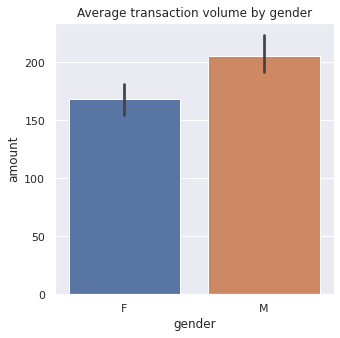

In [88]:
plt.figure(figsize = (5, 5))
sns.barplot(x = "gender", y = "amount", data = data)
plt.title("Average transaction volume by gender")

Male has a higher average transaction volume.

**3.1.7. Merchant suburb** 

In [89]:
data.merchant_suburb.value_counts(dropna = False)

NaN                 4326
Melbourne            255
Sydney               233
Southport             82
Brisbane City         79
                    ... 
Fig Tree Pocket        1
Dover                  1
Saint Kilda West       1
Jamisontown            1
Crestmead              1
Name: merchant_suburb, Length: 1610, dtype: int64

These are the suburbs where the transactions were made.

**3.1.8. Merchant state**

In [90]:
data.merchant_state.value_counts(dropna = False)

NaN    4326
NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merchant_state, dtype: int64

Text(0.5, 1.0, 'Number of transactions by state')

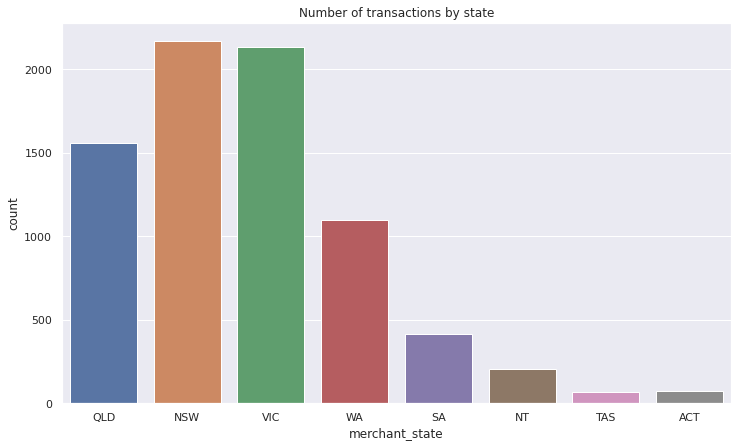

In [91]:
plt.figure(figsize = (12, 7))
sns.countplot(data.merchant_state)
plt.title("Number of transactions by state")

Similar to merchant suburb, these are the states where the transactions were made.

NSW and VIC are the top 2 states in number of transactions.

In [92]:
data[["merchant_state", "amount"]].groupby("merchant_state", as_index = False).mean().sort_values(by = "amount", ascending = False)

,merchant_state,amount
0,ACT,66.803836
1,NSW,47.036316
2,NT,44.726293
6,VIC,41.099953
4,SA,40.425470
3,QLD,34.372397
7,WA,30.901873
5,TAS,28.866618


Text(0.5, 1.0, 'Average transaction volume by state')

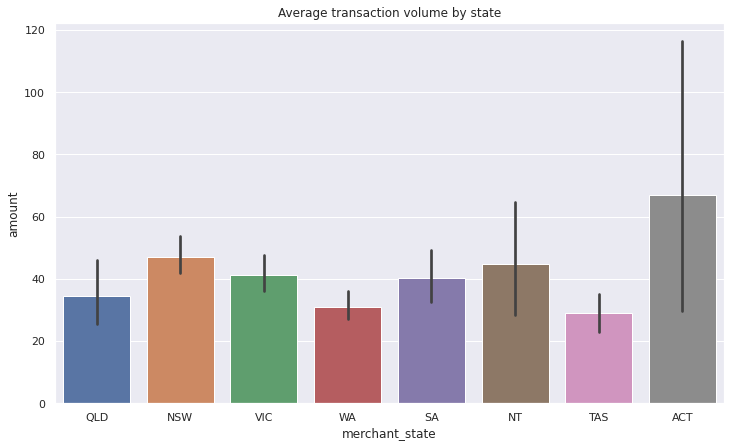

In [93]:
plt.figure(figsize = (12, 7))
sns.barplot(x = "merchant_state", y = "amount", data = data)
plt.title("Average transaction volume by state")

ACT has the highest average transaction volume but the variance is quite large.

**3.1.9. Extraction**

In [94]:
data.extraction.head()

0    2018-08-01T01:01:15.000+0000
1    2018-08-01T01:13:45.000+0000
2    2018-08-01T01:26:15.000+0000
3    2018-08-01T01:38:45.000+0000
4    2018-08-01T01:51:15.000+0000
Name: extraction, dtype: object

This appears to be the timestamp for each transaction. We can cross-reference this with the date column.


In [95]:
data[["date", "extraction"]].head()

,date,extraction
0,2018-08-01,2018-08-01T01:01:15.000+0000
1,2018-08-01,2018-08-01T01:13:45.000+0000
2,2018-08-01,2018-08-01T01:26:15.000+0000
3,2018-08-01,2018-08-01T01:38:45.000+0000
4,2018-08-01,2018-08-01T01:51:15.000+0000


Since we already have an existing date column, we can potentially extract only the time component out of the extraction column.

**3.1.10. Country**

In [96]:
data.country.value_counts(dropna = False)

Australia    12043
Name: country, dtype: int64

All transactions were recorded within Australia. Therefore, can consider dropping this column since it does not provide us with any information.

**3.1.11. Merchant longitude and latitude**

In [97]:
data.merchant_long_lat.head()

0    153.38 -27.99
1    151.21 -33.87
2    151.21 -33.87
3    153.05 -26.68
4    153.44 -28.06
Name: merchant_long_lat, dtype: object

These are the coordinates of the merchants' location.

**3.1.12. Movement (debit/credit)**

In [98]:
data.movement.value_counts(dropna = False)

debit     11160
credit      883
Name: movement, dtype: int64

Text(0.5, 1.0, 'Number of transactions by movement')

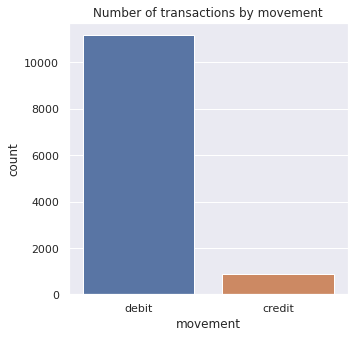

In [99]:
plt.figure(figsize = (5 ,5))
sns.countplot(data.movement)
plt.title("Number of transactions by movement")

Most transactions are overwhelmingly debit transactions.

Text(0.5, 1.0, 'Average transaction volume by movement')

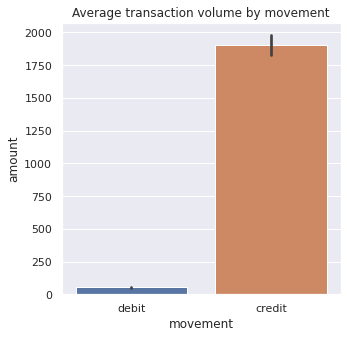

In [100]:
plt.figure(figsize = (5, 5))
sns.barplot(x = "movement", y = "amount", data = data)
plt.title("Average transaction volume by movement")


However, the average transaction amount for credit transactions are much higher.

### **3.2 Numerical variables**

**3.2.1. Balance**

Text(0.5, 1.0, 'Balance distribution')

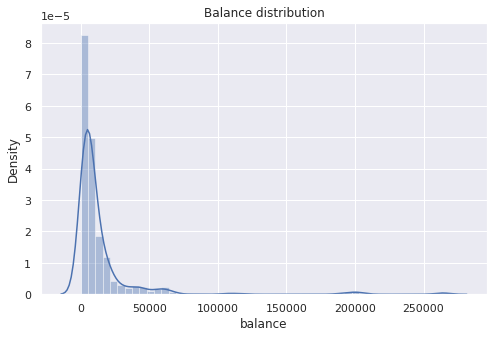

In [101]:
plt.figure(figsize = (8, 5))
sns.distplot(data.balance)
plt.title("Balance distribution")

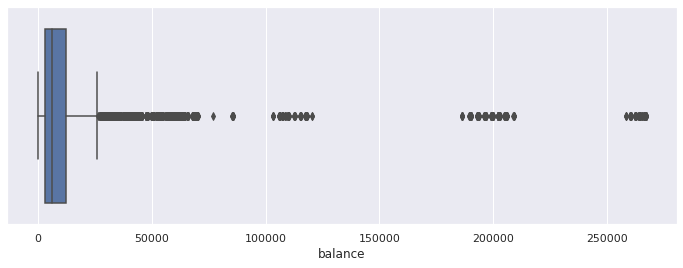

In [102]:
plt.figure(figsize = (12, 4))
sns.boxplot(data.balance)

Distribution of the balance feature has a long tail.

**3.2.2. Age of customers**

Text(0.5, 1.0, 'Age distribution')

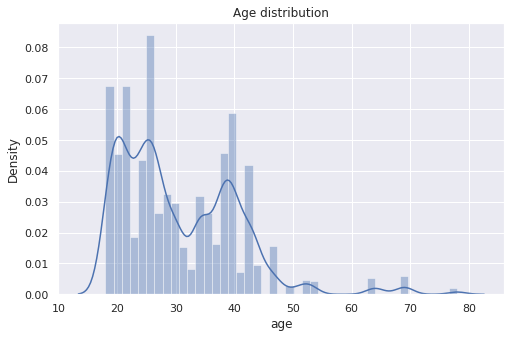

In [103]:
plt.figure(figsize = (8, 5))
sns.distplot(data.age)
plt.title("Age distribution")

Majority of the customers belong in the 20-25 age bracket.

**3.2.3. Transaction amount**

Text(0.5, 1.0, 'Amount distribution')

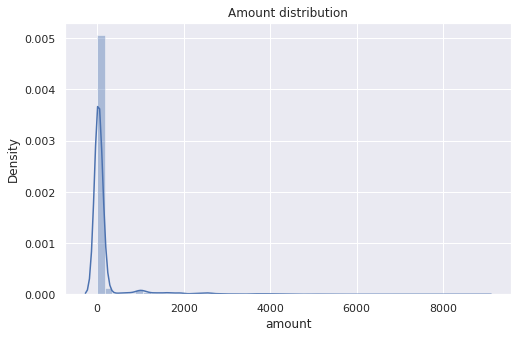

In [104]:
plt.figure(figsize = (8, 5))
sns.distplot(data.amount)
plt.title("Amount distribution")

# **4. General cleaning**



In this section, we are going to focus on dropping unwanted columns, deal with missing values and finally create some additional features that will make our data analysis more detailed and robust.

### **4.1. Drop unwanted columns**

Drop currency and country columns as they do not provide any aditional information.

In [105]:
print("Before: ", data.shape)
data = data.drop(["currency", "country"], axis = 1)
print("After: ", data.shape)

Before:  (12043, 23)
After:  (12043, 21)


### **4.2. Deal with missing values**

In [106]:
pd.DataFrame({"Number of missing values": missing, "Percentage": missing_percentage}).sort_values(by = "Percentage", ascending = False)

,Number of missing values,Percentage
bpay_biller_code,11158,92.7
merchant_code,11160,92.7
card_present_flag,4326,35.9
merchant_id,4326,35.9
merchant_suburb,4326,35.9
merchant_state,4326,35.9
merchant_long_lat,4326,35.9


Let's investigate if there is a reason behind these missing values.

Recall that not all transactions are purchases-related, could this imply the missing values in the merchant columns?

In [107]:
nonSales = data.loc[(data.txn_description != "SALES-POS") | (data.txn_description != "POS"), :]
nonSales.isnull().sum().sort_values(ascending = False)

merchant_code        11160
bpay_biller_code     11158
card_present_flag     4326
merchant_state        4326
merchant_suburb       4326
merchant_id           4326
merchant_long_lat     4326
movement                 0
first_name               0
account                  0
long_lat                 0
txn_description          0
date                     0
balance                  0
gender                   0
age                      0
extraction               0
amount                   0
transaction_id           0
customer_id              0
status                   0
dtype: int64

Missing values in the following columns 
all originate from non-purchases transactions:

*   card_present_flag
*   merchant_state
*   merchant_suburb
*   merchant_id
*   merchant_long_lat

We will fill these missing values with n/a.

In [108]:
cols = ["card_present_flag", "merchant_state", "merchant_suburb", "merchant_id", "merchant_long_lat"]
for col in cols:
    data[col].fillna("n/a", inplace = True)

In [109]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending = False)

merchant_code       11160
bpay_biller_code    11158
dtype: int64

Both merchant_code and bpay_biller_code are severely missing, around 93%. Therefore, we will drop those 2 columns from the dataframe.

In [110]:
data = data.drop(["merchant_code", "bpay_biller_code"], axis = 1)

Now, make sure there are no more missing data.

In [111]:
data.isnull().sum().max()

0

### **4.3. Create features for month, dayofweek and hour**

In [112]:
daily_amount = pd.DataFrame(data.groupby("date").amount.sum())
daily_amount.head()

,amount
date,
2018-08-01,29867.94
2018-08-02,21786.32
2018-08-03,38096.58
2018-08-04,6296.05
2018-08-05,4426.50


Text(0, 0.5, 'Transaction volume')

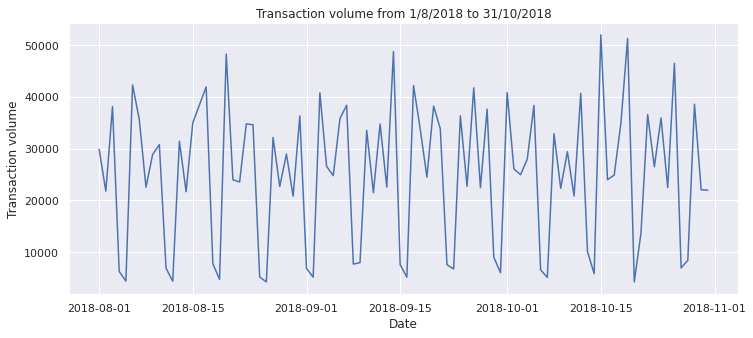

In [113]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(daily_amount.index, daily_amount.amount)
plt.title("Transaction volume from 1/8/2018 to 31/10/2018")
plt.xlabel("Date")
plt.ylabel("Transaction volume")

There appears to be a cyclical pattern in transaction volume over the 3 month period, because salaries are paid out only on certain days of the week.
People tend to spend more during the weekends (shopping, going out with friends etc).
We will move forward with this analysis by creating 3 new features from both the date and extraction columns:

*   month
*   dayofweek
*   hour

In [114]:
data["month"] = pd.DatetimeIndex(data.date).month
data["dayofweek"] = pd.DatetimeIndex(data.date).dayofweek
data[["date", "month", "dayofweek"]].head()

,date,month,dayofweek
0,2018-08-01,8,2
1,2018-08-01,8,2
2,2018-08-01,8,2
3,2018-08-01,8,2
4,2018-08-01,8,2


In addition to month and day of week, we can also get the hour in which those transactions took place from the extraction column.

I will update the extraction column such that it only contains the time. Then, I will create a new hour column which contains only the hour component of each transaction.

In [115]:
data.extraction.head()

0    2018-08-01T01:01:15.000+0000
1    2018-08-01T01:13:45.000+0000
2    2018-08-01T01:26:15.000+0000
3    2018-08-01T01:38:45.000+0000
4    2018-08-01T01:51:15.000+0000
Name: extraction, dtype: object

In [116]:
data["hour"] = [time.split(":")[0] for time in data.extraction]
data[["extraction", "hour"]].head()

,extraction,hour
0,2018-08-01T01:01:15.000+0000,2018-08-01T01
1,2018-08-01T01:13:45.000+0000,2018-08-01T01
2,2018-08-01T01:26:15.000+0000,2018-08-01T01
3,2018-08-01T01:38:45.000+0000,2018-08-01T01
4,2018-08-01T01:51:15.000+0000,2018-08-01T01


# **5. Advanced Analysis**

Our dataframe is in a much better shape and we have new features to work with, let's now do a deep dive and see if we can gather any interesting insights about customers' transactional behaviour.

In [118]:
data.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour
0,authorized,1,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,2018-08-01T01
1,authorized,0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,2018-08-01T01
2,authorized,1,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,2018-08-01T01
3,authorized,1,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,2018-08-01T01
4,authorized,1,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,2018-08-01T01


### **5.1. Purchases amount and overall amount**

In [119]:
purchases_amount = data.loc[(data.txn_description == "POS") | (data.txn_description == "SALES-POS"), "amount"]
purchases_amount.head()

0    16.25
1    14.19
2     6.42
3    40.90
4     3.25
Name: amount, dtype: float64

Text(0.5, 1.0, 'Purchase transaction amount')

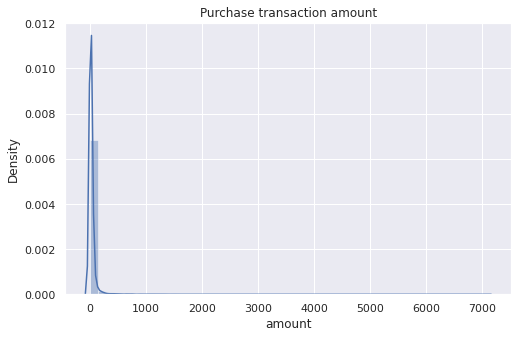

In [120]:
plt.figure(figsize = (8, 5))
sns.distplot(purchases_amount)
plt.title("Purchase transaction amount")

In [121]:
purchases_amount.describe()

count    7717.000000
mean       40.153732
std       149.833070
min         0.100000
25%        12.080000
50%        19.700000
75%        33.910000
max      7081.090000
Name: amount, dtype: float64

Text(0.5, 1.0, 'Overall transaction amount')

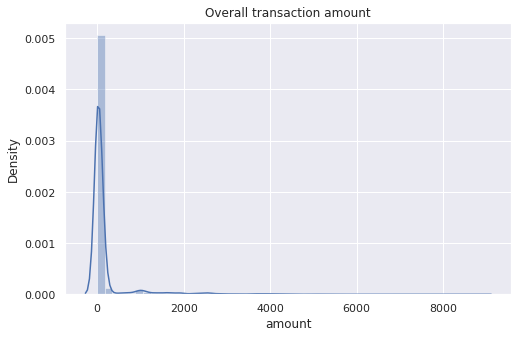

In [122]:
plt.figure(figsize = (8, 5))
sns.distplot(data.amount)
plt.title("Overall transaction amount")

In [123]:
data.amount.describe()

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64

Variance in overall transaction amount is much higher than purchases transaction amount due to the inclusion of salary payments.

### **5.2. Transaction volume per customer**

In [124]:
customer_monthly_volume = pd.DataFrame(data.groupby("customer_id").amount.sum() / 3) 
customer_monthly_volume.head()

,amount
customer_id,
CUS-1005756958,5422.990000
CUS-1117979751,11328.123333
CUS-1140341822,5670.200000
CUS-1147642491,9660.273333
CUS-1196156254,12016.906667


Text(0.5, 1.0, "Customers' monthly transaction volume")

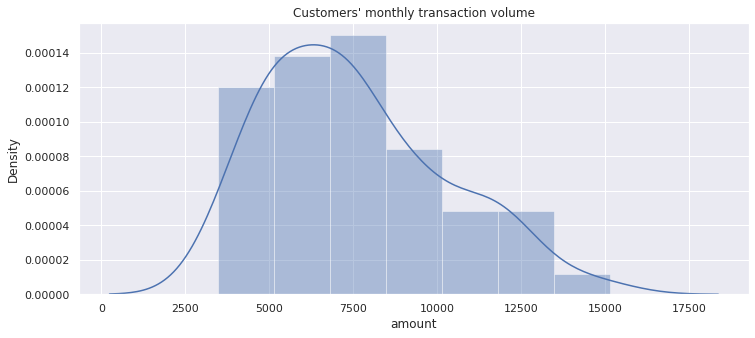

In [125]:
plt.figure(figsize = (12, 5))
sns.distplot(customer_monthly_volume.amount)
plt.title("Customers' monthly transaction volume")

### **5.3. Transaction volume over time**

Text(0.5, 1.0, 'Average transaction volume by month')

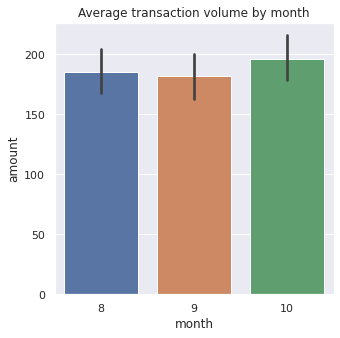

In [126]:
plt.figure(figsize = (5, 5))
sns.barplot(x = "month", y = "amount", data = data)
plt.title("Average transaction volume by month")

In [127]:
average_daily_volume = pd.DataFrame(data.groupby("dayofweek").amount.mean())
average_daily_volume.head()

,amount
dayofweek,
0,373.221000
1,221.576456
2,195.215570
3,184.010422
4,249.353517


Text(0.5, 0, 'Day of week')

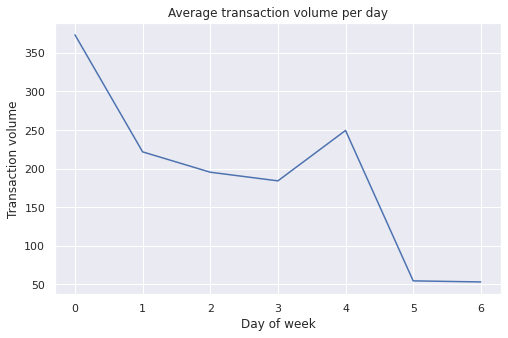

In [128]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(average_daily_volume.index, average_daily_volume.amount)
plt.title("Average transaction volume per day")
plt.ylabel("Transaction volume")
plt.xlabel("Day of week")

Friday and Saturday have the lowest average transaction volume. Let's see a breakdown of these transactions by types of transactions.

To simplify the categories, I will group all transactions into 3 categories:

*   Salary
*   Purchase
*   Others




In [129]:
data.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [130]:
data.loc[data.txn_description == "PAY/SALARY", "category"] = "Salary"
data.loc[(data.txn_description == "SALES-POS") | (data.txn_description == "POS"), "category"] = "Purchase"
data.category.fillna("Others", inplace = True)
data[["txn_description", "category"]].head(10)

,txn_description,category
0,POS,Purchase
1,SALES-POS,Purchase
2,POS,Purchase
3,SALES-POS,Purchase
4,SALES-POS,Purchase
5,PAYMENT,Others
6,SALES-POS,Purchase
7,POS,Purchase
8,POS,Purchase
9,INTER BANK,Others


Text(0.5, 0, 'Day of week')

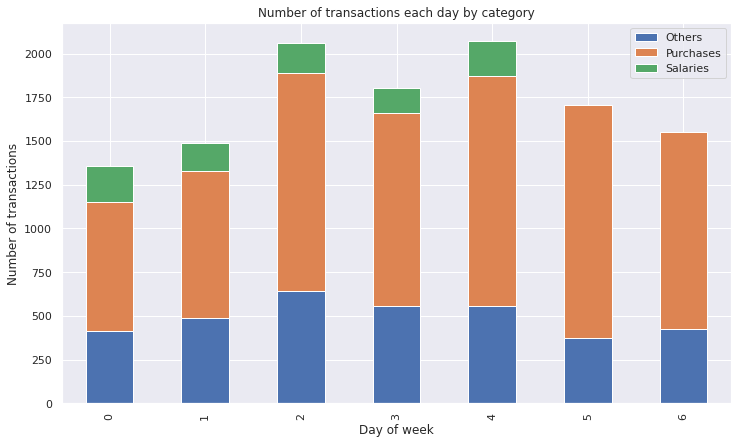

In [131]:
stacked_barplot = pd.DataFrame(data.groupby(["dayofweek", "category"]).amount.count())
stacked_barplot.unstack().plot(kind = "bar", stacked = True, figsize = (12, 7))
plt.title("Number of transactions each day by category")
plt.legend(["Others", "Purchases", "Salaries"])
plt.ylabel("Number of transactions")
plt.xlabel("Day of week")

No salaries were paid on Friday and Saturday, therefore lower average transaction volume on those days.

Also, it does not seem to appear that people spend more on purchases over the weekends

In [132]:
average_hourly_volume = pd.DataFrame(data.groupby("hour").amount.mean())
average_hourly_volume.head()

,amount
hour,
2018-08-01T01,16.202
2018-08-01T02,112.030
2018-08-01T04,17.430
2018-08-01T06,20.770
2018-08-01T07,24.930


Text(0.5, 0, 'Hour')

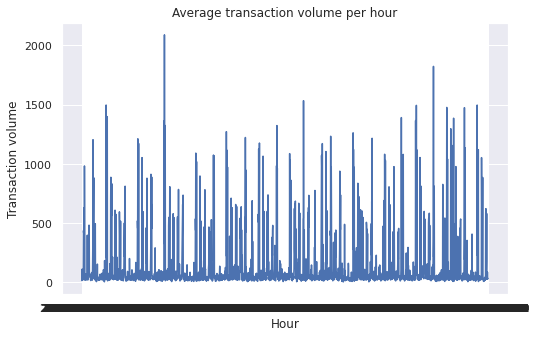

In [133]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(average_hourly_volume.index, average_hourly_volume.amount)
plt.title("Average transaction volume per hour")
plt.ylabel("Transaction volume")
plt.xlabel("Hour")

Highest transaction volumes happen during the midday and late afternoon. Let's see a breakdown of these transactions by categories.

Text(0.5, 0, 'Hour')

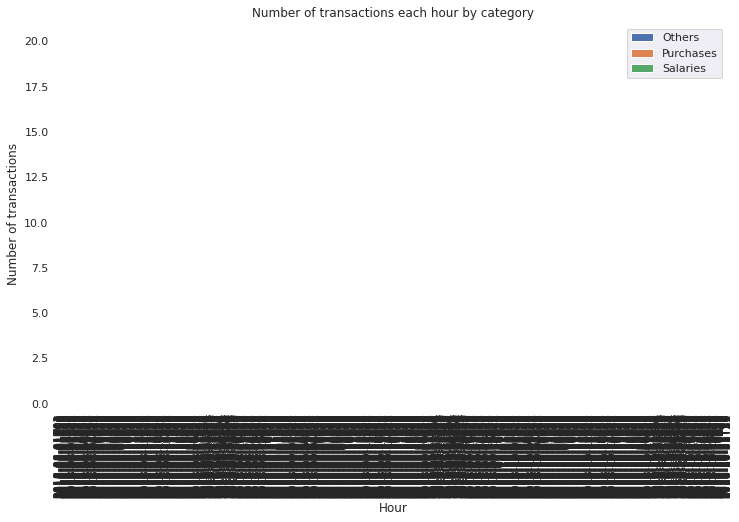

In [134]:
stacked_barplot = pd.DataFrame(data.groupby(["hour", "category"]).amount.count())
stacked_barplot.unstack().plot(kind = "bar", stacked = True, figsize = (12, 7))
plt.title("Number of transactions each hour by category")
plt.legend(["Others", "Purchases", "Salaries"])
plt.ylabel("Number of transactions")
plt.xlabel("Hour")

### **5.4. Distance between customers and merchants**

An additional challenge that we could do is figuring out the distance between the customers and the merchants and analyse its distribution.

This can be done via the haversine library in Python which calculates the distance between two points on the Earth using their latitude and longitude. We can obtain the latitude and longitude of both the customers and merchants from the following columns:

*   long_lat
*   merchant_long_lat

In [135]:
data[["long_lat", "merchant_long_lat"]].head()

,long_lat,merchant_long_lat
0,153.41 -27.95,153.38 -27.99
1,153.41 -27.95,151.21 -33.87
2,151.23 -33.94,151.21 -33.87
3,153.10 -27.66,153.05 -26.68
4,153.41 -27.95,153.44 -28.06


# **6. Save data**

In [138]:
data.to_pickle('/content/gdrive/My Drive/data.pkl')